/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Episode 1: Total Reward: -26.20, Epsilon: 0.99
Episode 2: Total Reward: -22.00, Epsilon: 0.99
Episode 3: Total Reward: -19.10, Epsilon: 0.99
Episode 4: Total Reward: -23.30, Epsilon: 0.98
Episode 5: Total Reward: -20.60, Epsilon: 0.98
Episode 6: Total Reward: -26.90, Epsilon: 0.97
Episode 7: Total Reward: -14.00, Epsilon: 0.97
Episode 8: Total Reward: -26.90, Epsilon: 0.96
Episode 9: Total Reward: -40.30, Epsilon: 0.96
Episode 10: Total Reward: -17.80, Epsilon: 0.95
Episode 11: Total Reward: -15.00, Epsilon: 0.95
Episode 12: Total Reward: -26.50, Epsilon: 0.94
Episode 13: Total Reward: -28.10, Epsilon: 0.94
Episode 14: Total Reward: -27.00, Epsilon: 0.93
Episode 15: Total Reward: -21.10, Epsilon: 0.93
Episode 16: Total Reward: -22.50, Epsilon: 0.92
Episode 17: Total Reward: -21.50, Epsilon: 0.92
Episode 18: Total Reward: -39.30, Epsilon: 0.91
Episode 19: Total Reward: -27.90, Epsilon: 0.91
Episode 20: Total Reward: -32.60, Epsilon: 0.90
Episode 21: Total Reward: -25.90, Epsilon: 0.90
E

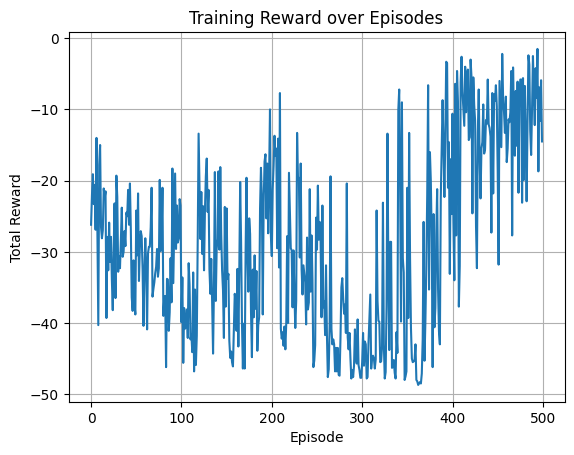

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import gym
from collections import deque
import random
import matplotlib.pyplot as plt

# Custom Smart Grid Environment
class SmartGridEnv(gym.Env):
    def __init__(self):
        super(SmartGridEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(3)  # 0: Reduce, 1: Maintain, 2: Increase
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
        self.state = np.random.rand(5)
        self.energy_demand = 0.5

    def reset(self):
        self.energy_demand = 0.5
        self.state = np.random.rand(5)
        return self.state

    def step(self, action):
        self.energy_demand += (action - 1) * 0.1  # More concise
        self.energy_demand = np.clip(self.energy_demand, 0, 1)
        self.state = np.random.rand(5)
        reward = -abs(self.energy_demand - 0.5)
        done = False
        return self.state, reward, done, {}

# Build the DQN Model
def build_dqn(input_shape, output_size):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(output_size, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# DQN Agent
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.state_size = env.observation_space.shape
        self.action_size = env.action_space.n
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = build_dqn(self.state_size, self.action_size)

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size - 1)
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []

        for s, a, r, s_next, done in minibatch:
            target = self.model.predict(np.array([s]), verbose=0)[0]
            if done:
                target[a] = r
            else:
                q_next = self.model.predict(np.array([s_next]), verbose=0)[0]
                target[a] = r + self.gamma * np.max(q_next)
            states.append(s)
            targets.append(target)

        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Training Loop
env = SmartGridEnv()
agent = DQNAgent(env)
episodes = 500
reward_log = []

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    for _ in range(100):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    agent.replay()
    reward_log.append(total_reward)
    print(f"Episode {ep+1}: Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

# Plotting reward trend
plt.plot(reward_log)
plt.title("Training Reward over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()
